In [5]:
# Imports for pytorch
import numpy as np
import torch
import torchvision
from torch import nn
import matplotlib
from matplotlib import pyplot as plt
# import tqdm
from tqdm import tqdm
import pdb
import random

In [6]:
np.random.seed(6312)
random.seed(7272)

# Part 1: Naive CNN
Last Spring, I took CS 189, where I build a CNN in a conventional way: Look at previous examples and blindly experiment off of them. I will start with that network, calculate the MEC, and make a better one.

Forgive me if some of the decisions here look silly, I did not know much about CNNs or deep learning back in the day.

In [7]:
from torchvision.transforms.autoaugment import F
### YOUR CODE HERE ###

def make_epoch_plot(epochs, train, valid, plt_type="Loss", problem_name="MLP on FashionMNIST"):
    plt.plot(epochs, train, label=f"Training {plt_type}")
    plt.plot(epochs, valid, label=f"Validation {plt_type}")
    plt.title(f'Training and Validation {plt_type} vs. Epochs for {problem_name}')
    plt.xlabel('Epoch Number')
    plt.ylabel(plt_type)
    plt.legend()
    plt.show()

In [9]:
# Creating the datasets, feel free to change this as long as you do the same to the test data.
# You can also modify this to split the data into training and validation.
# See https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split

transform = torchvision.transforms.ToTensor()

training_data = torchvision.datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=transform,
)
print(len(training_data))
validation_data = torchvision.datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=transform,
)

print(len(validation_data))
# If you make a train-test partition it is up to you.

Files already downloaded and verified
50000
Files already downloaded and verified
10000


In [20]:
print(training_data[1][0].shape)
print(len(training_data))

torch.Size([3, 32, 32])
50000


## The Original CNN

In [23]:
class MikeNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 128, 3)
    self.conv2 = nn.Conv2d(128, 256, 3)
    self.dropout1 = nn.Dropout(0.4)
    self.conv3 = nn.Conv2d(256, 512, 3)
    self.dropout2 = nn.Dropout(0.4)
    self.conv4 = nn.Conv2d(512, 1024, 3)

    # an affine operation: y = Wx + b
    self.fc1 = nn.Linear(1024 * 3 * 3, 512)
    self.dropout3 = nn.Dropout(0.4)
    self.fc2 = nn.Linear(512, 128)
    self.fc3 = nn.Linear(128, 10)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2)
    # If the size is a square, you can specify with a single number
    x = F.relu(self.conv2(x))
    x = self.dropout1(x)
    x = F.relu(self.conv3(x))
    x = F.max_pool2d(x, 2)
    x = F.relu(self.conv4(x))
    x = self.dropout2(x)
    #x = F.relu(self.conv5(x))
    x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
    x = F.relu(self.fc1(x))
    x = self.dropout3(x)
    x = F.relu(self.fc2(x))
    #x = F.softmax(self.fc3(x), dim=1)
    x = self.fc3(x)
    return x

In [24]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", device)
criterion = torch.nn.CrossEntropyLoss()


def predict(model, dataloader, test=False):
  with torch.no_grad():
      losses = []
      model.eval() # Put model in eval mode
      num_correct = 0
      # i = 0
      # pred_vec = torch.zeros([len(dataloader.dataset), 1])
      pred_vec = []
      for x, y in dataloader:
          x, y = x.float().to(device), y.float().to(device)
          pred = model(x)
          pred_nums = torch.argmax(pred, dim=1)
          correct_in_batch = torch.sum(torch.round(pred_nums) == y).item()
          # if correct_in_batch < 5:
          #     #print(f"MAJOR ISSUE: correct_in_batch: {correct_in_batch}")
          #     print(f"pred: {pred}")
          #     print(f"pred_nums: {pred_nums}")
          #     print(f"correct_in_batch: {correct_in_batch};  len(x): {x.shape[0]}")
          #     print(f"y: {y}")
          #     print(f"Thing: {torch.round(pred_nums) == y}")
          num_correct += correct_in_batch
          loss = criterion(pred, y.long())
          losses.append(loss.item())
          if test:
            pred_vec += torch.flatten(pred_nums).tolist()
      acc = num_correct / len(dataloader.dataset)

      #print(f"Accuracy: {acc}; num_correct: {num_correct}; length: {len(dataloader.dataset)}")
      mean_loss = np.mean(losses)
      model.train() # Put model back in train mode
      return acc, mean_loss


Using device cuda


## Training the Original CNN

  0%|          | 0/5556 [00:00<?, ?batch/s]

Using device cuda


100%|██████████| 5556/5556 [00:26<00:00, 206.76batch/s]


Finished Epoch 1!
Predicting for training...
Training loss: 1.517424832871271 ... Training accuracy: 0.45478
Predicting for validation...


  0%|          | 22/5556 [00:00<00:25, 214.14batch/s]

Validation loss: 1.5302204634431456 ... Validation accuracy: 0.4481


100%|██████████| 5556/5556 [00:29<00:00, 189.66batch/s]


Finished Epoch 2!
Predicting for training...
Training loss: 1.1064343390553182 ... Training accuracy: 0.60976
Predicting for validation...


  0%|          | 22/5556 [00:00<00:26, 212.43batch/s]

Validation loss: 1.1512884499250555 ... Validation accuracy: 0.5974


100%|██████████| 5556/5556 [00:31<00:00, 177.44batch/s]


Finished Epoch 3!
Predicting for training...
Training loss: 0.9997843668224187 ... Training accuracy: 0.6368
Predicting for validation...


  0%|          | 24/5556 [00:00<00:23, 237.40batch/s]

Validation loss: 1.0912434818531327 ... Validation accuracy: 0.6043


100%|██████████| 5556/5556 [00:30<00:00, 179.64batch/s]


Finished Epoch 4!
Predicting for training...
Training loss: 0.7648875105072046 ... Training accuracy: 0.73918
Predicting for validation...


  0%|          | 22/5556 [00:00<00:25, 219.12batch/s]

Validation loss: 0.9160139292290956 ... Validation accuracy: 0.6888


100%|██████████| 5556/5556 [00:26<00:00, 207.12batch/s]


Finished Epoch 5!
Predicting for training...
Training loss: 0.7338742803536822 ... Training accuracy: 0.74832
Predicting for validation...


  0%|          | 24/5556 [00:00<00:23, 232.88batch/s]

Validation loss: 0.9323232396499073 ... Validation accuracy: 0.6822


100%|██████████| 5556/5556 [00:30<00:00, 180.03batch/s]


Finished Epoch 6!
Predicting for training...
Training loss: 0.5234527597979953 ... Training accuracy: 0.82124
Predicting for validation...


  0%|          | 22/5556 [00:00<00:25, 218.32batch/s]

Validation loss: 0.7710680834674309 ... Validation accuracy: 0.7393


100%|██████████| 5556/5556 [00:31<00:00, 179.02batch/s]


Finished Epoch 7!
Predicting for training...
Training loss: 0.4813612438303779 ... Training accuracy: 0.83812
Predicting for validation...


  0%|          | 24/5556 [00:00<00:24, 229.09batch/s]

Validation loss: 0.7887849338598074 ... Validation accuracy: 0.7392


100%|██████████| 5556/5556 [00:30<00:00, 179.79batch/s]


Finished Epoch 8!
Predicting for training...
Training loss: 0.40253843269676315 ... Training accuracy: 0.86618
Predicting for validation...


  0%|          | 22/5556 [00:00<00:26, 211.02batch/s]

Validation loss: 0.7665490714084398 ... Validation accuracy: 0.7547


100%|██████████| 5556/5556 [00:31<00:00, 174.75batch/s]


Finished Epoch 9!
Predicting for training...
Training loss: 0.4988941950596134 ... Training accuracy: 0.82872
Predicting for validation...


  0%|          | 23/5556 [00:00<00:25, 219.62batch/s]

Validation loss: 0.8441822170380423 ... Validation accuracy: 0.7208


100%|██████████| 5556/5556 [00:31<00:00, 176.14batch/s]


Finished Epoch 10!
Predicting for training...
Training loss: 0.35774919996758864 ... Training accuracy: 0.88444
Predicting for validation...
Validation loss: 0.7395309744613822 ... Validation accuracy: 0.7548


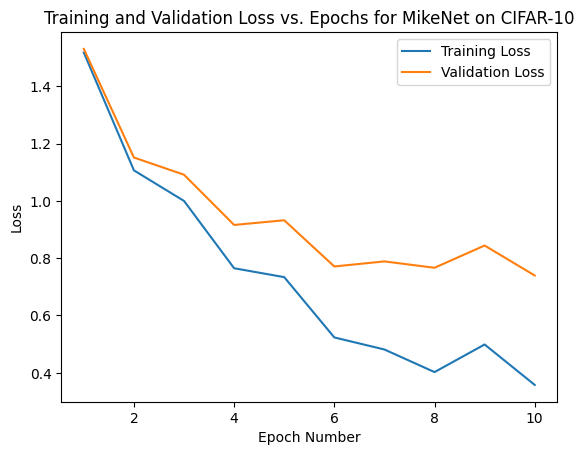

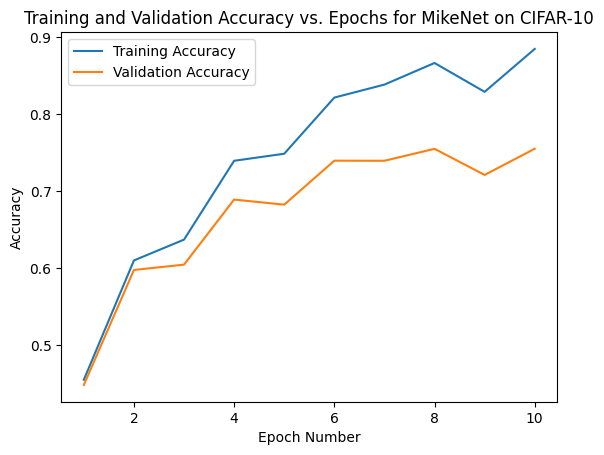

In [25]:
### YOUR CODE HERE ###
import torch.nn.functional as F


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", device)

epochs = 10
batch_size = 9
learning_rate = 0.005
#learning_rate = 0.01

num_features = np.prod(list(training_data[0][0].shape))
#print(f"Num features: {num_features}; Model params: {model.parameters()}")
model = MikeNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=True)

model.train() # Put model in training mode
train_accs = []
valid_accs = []
mean_train_losses = []
mean_valid_losses = []
epoch_list = []
for epoch in range(epochs):
    for x, y in tqdm(train_dataloader, unit="batch"):
        #x = torch.reshape(x, (x.shape[0], -1))
        x, y = x.float().to(device), y.float().to(device)
        optimizer.zero_grad() # Remove the gradients from the previous step
        pred = model(x)
        loss = criterion(pred, y.long())
        loss.backward()
        optimizer.step()
        #train_losses.append(loss.item())

    print(f"Finished Epoch {epoch + 1}!")
    epoch_list.append(epoch + 1)
    print("Predicting for training...")
    train_acc, train_loss = predict(model, train_dataloader)
    print(f"Training loss: {train_loss} ... Training accuracy: {train_acc}")
    print("Predicting for validation...")
    valid_acc, valid_loss = predict(model, valid_dataloader)
    print(f"Validation loss: {valid_loss} ... Validation accuracy: {valid_acc}")

    train_accs.append(train_acc)
    valid_accs.append(valid_acc)
    mean_train_losses.append(train_loss)
    mean_valid_losses.append(valid_loss)


    # print(f"Finished Epoch{epoch + 1}\nTraining loss: {np.mean(train_losses)}")

# We can run predictions on the data to determine the final accuracy.
make_epoch_plot(epoch_list, mean_train_losses, mean_valid_losses, plt_type="Loss", problem_name="MikeNet on CIFAR-10")
make_epoch_plot(epoch_list, train_accs, valid_accs, plt_type="Accuracy", problem_name="MikeNet on CIFAR-10")




## Original Model Analysis

### Performance: The model acheives 90% train accuracy and 75.6% validation accuracy

### Let's look at the architecture

```
self.conv1 = nn.Conv2d(3, 128, 3) 
self.conv2 = nn.Conv2d(128, 256, 3) # input: [b, 30, 30, 128]. output: [b, 28, 28, 256]
self.dropout1 = nn.Dropout(0.4)
self.conv3 = nn.Conv2d(256, 512, 3) # input: [b, 28, 28, 256]. output: [b, 26, 26, 512]
self.dropout2 = nn.Dropout(0.4)
self.conv4 = nn.Conv2d(512, 1024, 3) # input: [b, 26, 26, 512]. output: [b, 24, 24, 1024]

self.fc1 = nn.Linear(1024 * 3 * 3, 512)
self.dropout3 = nn.Dropout(0.4)
self.fc2 = nn.Linear(512, 128)
self.fc3 = nn.Linear(128, 10)


def forward(self, x):
    x = F.relu(self.conv1(x)) # input: [b, 32, 32, 3]. output: [b, 30, 30, 128]
    x = F.max_pool2d(x, 2) # input: [b, 32, 32, 3]. output: [b, 15, 15, 128]
    x = F.relu(self.conv2(x)) # input: [b, 15, 15, 128]. output: [b, 13, 13, 256]
    x = self.dropout1(x)
    x = F.relu(self.conv3(x)) # input: [b, 13, 13, 256]. output: [b, 11, 11, 512]
    x = F.max_pool2d(x, 2) # input: [b, 11, 11, 512]. output: [b, 5, 5, 512]
    x = F.relu(self.conv4(x)) # input: [b, 5, 5, 512]. output: [b, 3, 3, 512]
    x = self.dropout2(x)
    x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
    x = F.relu(self.fc1(x))
    x = self.dropout3(x)
    x = F.relu(self.fc2(x))
    #x = F.softmax(self.fc3(x), dim=1)
    x = self.fc3(x)
    return x

```

### Compression
In terms of compression from the convolution, I have discovered something quite silly about this network... It seems this network didn't actually compress anything at all.
That is, the compression ratio is: b * 32 * 32 * 3 / (b * 3 * 3 * 1024) = 1/3
(Again, in my defense, I really did not know what I was doing, but at least these methods formalize that I did not know wtf I was doing.)
By the data impression inequality, this part of the model is too big jusy by the fact that I am trying to "create" information

### MEC: 

(1024 * 3 * 3 + 1) * 512 + 512 + 128 = 4719744 bits MEC 
Wow that's way too much!




In [16]:
def conv_output_dim(input_dim, pad, kernel, stride):
    return int((input_dim + 2 * pad - kernel) / stride + 1)

def pool_output_dim(input_dim, pad, kernel, stride):
    return int((input_dim + 2 * pad - (kernel - 1) - 1) / stride + 1)

In [22]:
conv_output_dim(3, 0, 2, 2)
# pool_output_dim(3, 0, 2, 2)

1

# Adjustments based off of MEC

### Calculating necessary MEC: 
There are 50000 data points and 10 classes. log_2(10) = 4. 4 * 50000 = 200000. 
Let's make the MLP of the following architecture:
(1024, 256)
(256, 64)
(64, 10)
This would have (1024 + 1) * 256 + 256 + 64 = 262720 bits of MEC. (Still 62720 over necessary).

Making the input to the MLP 1024 features would also make the compression 32 * 32 * 3 / 1024 = 3


### New CNN

In [26]:
class MikeNetMEC(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 128, 3)
    self.conv2 = nn.Conv2d(128, 256, 3)
    self.dropout1 = nn.Dropout(0.2)
    self.conv3 = nn.Conv2d(256, 512, 3)
    self.dropout2 = nn.Dropout(0.1)
    self.conv4 = nn.Conv2d(512, 1024, 3)

    # an affine operation: y = Wx + b
    self.fc1 = nn.Linear(1024, 256)
    self.dropout3 = nn.Dropout(0.2)
    self.fc2 = nn.Linear(256, 64)
    self.fc3 = nn.Linear(64, 10)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    # If the size is a square, you can specify with a single number
    x = F.relu(self.conv2(x))
    
    x = F.relu(self.conv3(x))
    x = F.max_pool2d(x, 2)
    x = F.relu(self.conv4(x))
    x = F.max_pool2d(x, 2)
    x = self.dropout2(x)
    #x = F.relu(self.conv5(x))
    x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
    x = F.relu(self.fc1(x))
    x = self.dropout3(x)
    x = F.relu(self.fc2(x))
    #x = F.softmax(self.fc3(x), dim=1)
    x = self.fc3(x)
    return x

  0%|          | 15/3334 [00:00<00:22, 149.06batch/s]

Using device cuda


100%|██████████| 3334/3334 [00:20<00:00, 160.15batch/s]


Finished Epoch 1!
Training loss: 1.7899553380330022 ... Training accuracy: 0.32712


  1%|          | 19/3334 [00:00<00:18, 180.31batch/s]

Validation loss: 1.7951755500447446 ... Validation accuracy: 0.3279


100%|██████████| 3334/3334 [00:22<00:00, 146.64batch/s]


Finished Epoch 2!
Training loss: 1.3325138891179475 ... Training accuracy: 0.51592


  1%|          | 19/3334 [00:00<00:18, 181.15batch/s]

Validation loss: 1.361345648765564 ... Validation accuracy: 0.5024


100%|██████████| 3334/3334 [00:22<00:00, 148.67batch/s]


Finished Epoch 3!
Training loss: 1.1609456065034323 ... Training accuracy: 0.59602


  1%|          | 19/3334 [00:00<00:17, 185.93batch/s]

Validation loss: 1.2055431588746977 ... Validation accuracy: 0.5776


100%|██████████| 3334/3334 [00:22<00:00, 148.72batch/s]


Finished Epoch 4!
Training loss: 1.0419568541427895 ... Training accuracy: 0.63584


  1%|          | 20/3334 [00:00<00:17, 189.36batch/s]

Validation loss: 1.134710854184681 ... Validation accuracy: 0.6074


100%|██████████| 3334/3334 [00:22<00:00, 145.58batch/s]


Finished Epoch 5!
Training loss: 0.9076615104828327 ... Training accuracy: 0.68652


  1%|          | 20/3334 [00:00<00:17, 189.66batch/s]

Validation loss: 1.0465983081346508 ... Validation accuracy: 0.6366


100%|██████████| 3334/3334 [00:20<00:00, 163.72batch/s]


Finished Epoch 6!
Training loss: 0.7617915560947827 ... Training accuracy: 0.7341


  1%|          | 20/3334 [00:00<00:17, 192.46batch/s]

Validation loss: 0.9567493454091016 ... Validation accuracy: 0.6658


100%|██████████| 3334/3334 [00:19<00:00, 168.61batch/s]


Finished Epoch 7!
Training loss: 0.6267216392688287 ... Training accuracy: 0.78998


  1%|          | 21/3334 [00:00<00:16, 200.24batch/s]

Validation loss: 0.8829316823021404 ... Validation accuracy: 0.701


100%|██████████| 3334/3334 [00:21<00:00, 157.35batch/s]


Finished Epoch 8!
Training loss: 0.5610835741072374 ... Training accuracy: 0.80498


  1%|          | 21/3334 [00:00<00:16, 202.16batch/s]

Validation loss: 0.9139908409301845 ... Validation accuracy: 0.6971


100%|██████████| 3334/3334 [00:21<00:00, 156.24batch/s]


Finished Epoch 9!
Training loss: 0.48551930721131853 ... Training accuracy: 0.83422


  1%|          | 19/3334 [00:00<00:17, 189.64batch/s]

Validation loss: 0.8872937363261046 ... Validation accuracy: 0.7102


100%|██████████| 3334/3334 [00:21<00:00, 153.40batch/s]


Finished Epoch 10!
Training loss: 0.4034803986468927 ... Training accuracy: 0.86574
Validation loss: 0.8595326313863452 ... Validation accuracy: 0.7155


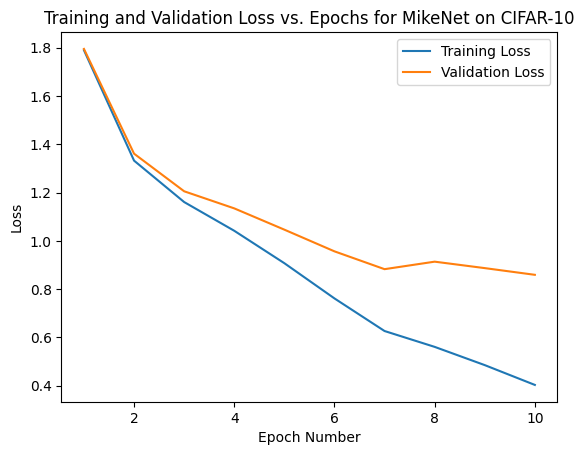

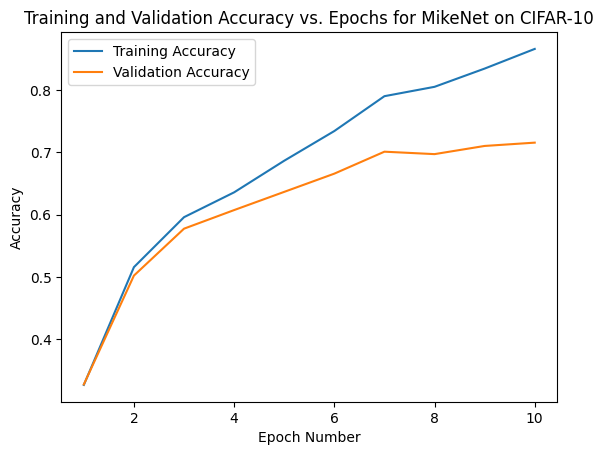

In [29]:
import torch.nn.functional as F


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", device)

epochs = 10
batch_size = 15
learning_rate = 0.005
# learning_rate = 0.01

num_features = np.prod(list(training_data[0][0].shape))
#print(f"Num features: {num_features}; Model params: {model.parameters()}")
model = MikeNetMEC().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=True)

model.train() # Put model in training mode
train_accs = []
valid_accs = []
mean_train_losses = []
mean_valid_losses = []
epoch_list = []
for epoch in range(epochs):
    for x, y in tqdm(train_dataloader, unit="batch"):
        #x = torch.reshape(x, (x.shape[0], -1))
        x, y = x.float().to(device), y.float().to(device)
        optimizer.zero_grad() # Remove the gradients from the previous step
        pred = model(x)
        loss = criterion(pred, y.long())
        loss.backward()
        optimizer.step()
        #train_losses.append(loss.item())

    print(f"Finished Epoch {epoch + 1}!")
    epoch_list.append(epoch + 1)
    # print("Predicting for training...")
    train_acc, train_loss = predict(model, train_dataloader)
    print(f"Training loss: {train_loss} ... Training accuracy: {train_acc}")
    # print("Predicting for validation...")
    valid_acc, valid_loss = predict(model, valid_dataloader)
    print(f"Validation loss: {valid_loss} ... Validation accuracy: {valid_acc}")

    train_accs.append(train_acc)
    valid_accs.append(valid_acc)
    mean_train_losses.append(train_loss)
    mean_valid_losses.append(valid_loss)


    # print(f"Finished Epoch{epoch + 1}\nTraining loss: {np.mean(train_losses)}")

# We can run predictions on the data to determine the final accuracy.
make_epoch_plot(epoch_list, mean_train_losses, mean_valid_losses, plt_type="Loss", problem_name="MikeNet on CIFAR-10")
make_epoch_plot(epoch_list, train_accs, valid_accs, plt_type="Accuracy", problem_name="MikeNet on CIFAR-10")

